In [3]:
import numpy as np
import numpyro as npr
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
import jax.numpy as jnp
import jax.scipy.special as jss
import arviz as az
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from numpyro.infer.reparam import TransformReparam

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
sns.set()

In [6]:
npr.set_host_device_count(mp.cpu_count())

# First toy model

## Data

In [21]:
# Seed
np.random.seed(123)

# Parameterization
mu = 6
sg_theta = 0.5
sg_u = 3
sg_w = 5

# Number of users
n_u = 20
# Number of words
n_w = 20
# Number of obs per user per word
n_o = 100

# Generate data
U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty

n_obs = n_w*n_u*n_o

u = np.zeros(n_obs, dtype=int)
w = np.zeros(n_obs, dtype=int)
theta = np.zeros(n_obs)

idx = 0
for i_w in range(n_w):
    for i_u in range(n_u):
        u[idx:idx+n_o] = i_u
        w[idx:idx+n_o] = i_w
        idx += n_o
theta = np.random.normal(mu + U[u] + W[w], sg_theta)

In [22]:
np.mean(theta)

4.9412931828600914

## Define the model

In [34]:
def model():
    sg_w = npr.sample("sg_w", dist.InverseGamma(1, 1))
    sg_u = npr.sample("sg_u", dist.InverseGamma(1, 1))
    sg_theta = npr.sample("sg_theta", dist.InverseGamma(1, 1))
    mu = npr.sample("mu", dist.Normal(0, 10));
    
    with npr.plate("user", n_u):
        U = npr.sample("U", 
                       dist.TransformedDistribution(dist.Normal(0., 1.), 
                                                    dist.transforms.AffineTransform(0, sg_u)))
    
    with npr.plate("word", n_w):
        W = npr.sample("W", 
                       dist.TransformedDistribution(dist.Normal(0., 1.), 
                                                    dist.transforms.AffineTransform(0, sg_w)))
    
    with npr.plate("n_obs", n_obs):
        npr.sample(f"theta", 
                   dist.TransformedDistribution(dist.Normal(0., 1.), 
                                                dist.transforms.AffineTransform(mu + U[u] + W[w], sg_theta)),
                   obs=theta)
    

In [35]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

sample: 100%|██████████| 2000/2000 [04:30<00:00,  7.39it/s, 159 steps of size 4.02e-03. acc. prob=0.93] 


In [36]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]     -3.49      0.74     -3.60     -4.61     -2.45     10.79      1.00
      U[1]      2.72      0.74      2.62      1.61      3.75     10.81      1.00
      U[2]      0.59      0.74      0.48     -0.53      1.62     10.81      1.00
      U[3]     -4.79      0.74     -4.89     -5.92     -3.78     10.81      1.00
      U[4]     -1.99      0.74     -2.09     -3.10     -0.95     10.81      1.00
      U[5]      4.67      0.74      4.57      3.56      5.70     10.82      1.00
      U[6]     -7.55      0.74     -7.66     -8.69     -6.53     10.80      1.00
      U[7]     -1.54      0.74     -1.64     -2.66     -0.50     10.79      1.00
      U[8]      3.54      0.74      3.44      2.43      4.58     10.81      1.00
      U[9]     -2.85      0.74     -2.96     -3.96     -1.82     10.82      1.00
     U[10]     -2.31      0.74     -2.42     -3.45     -1.30     10.81      1.00
     U[11]     -0.56      0

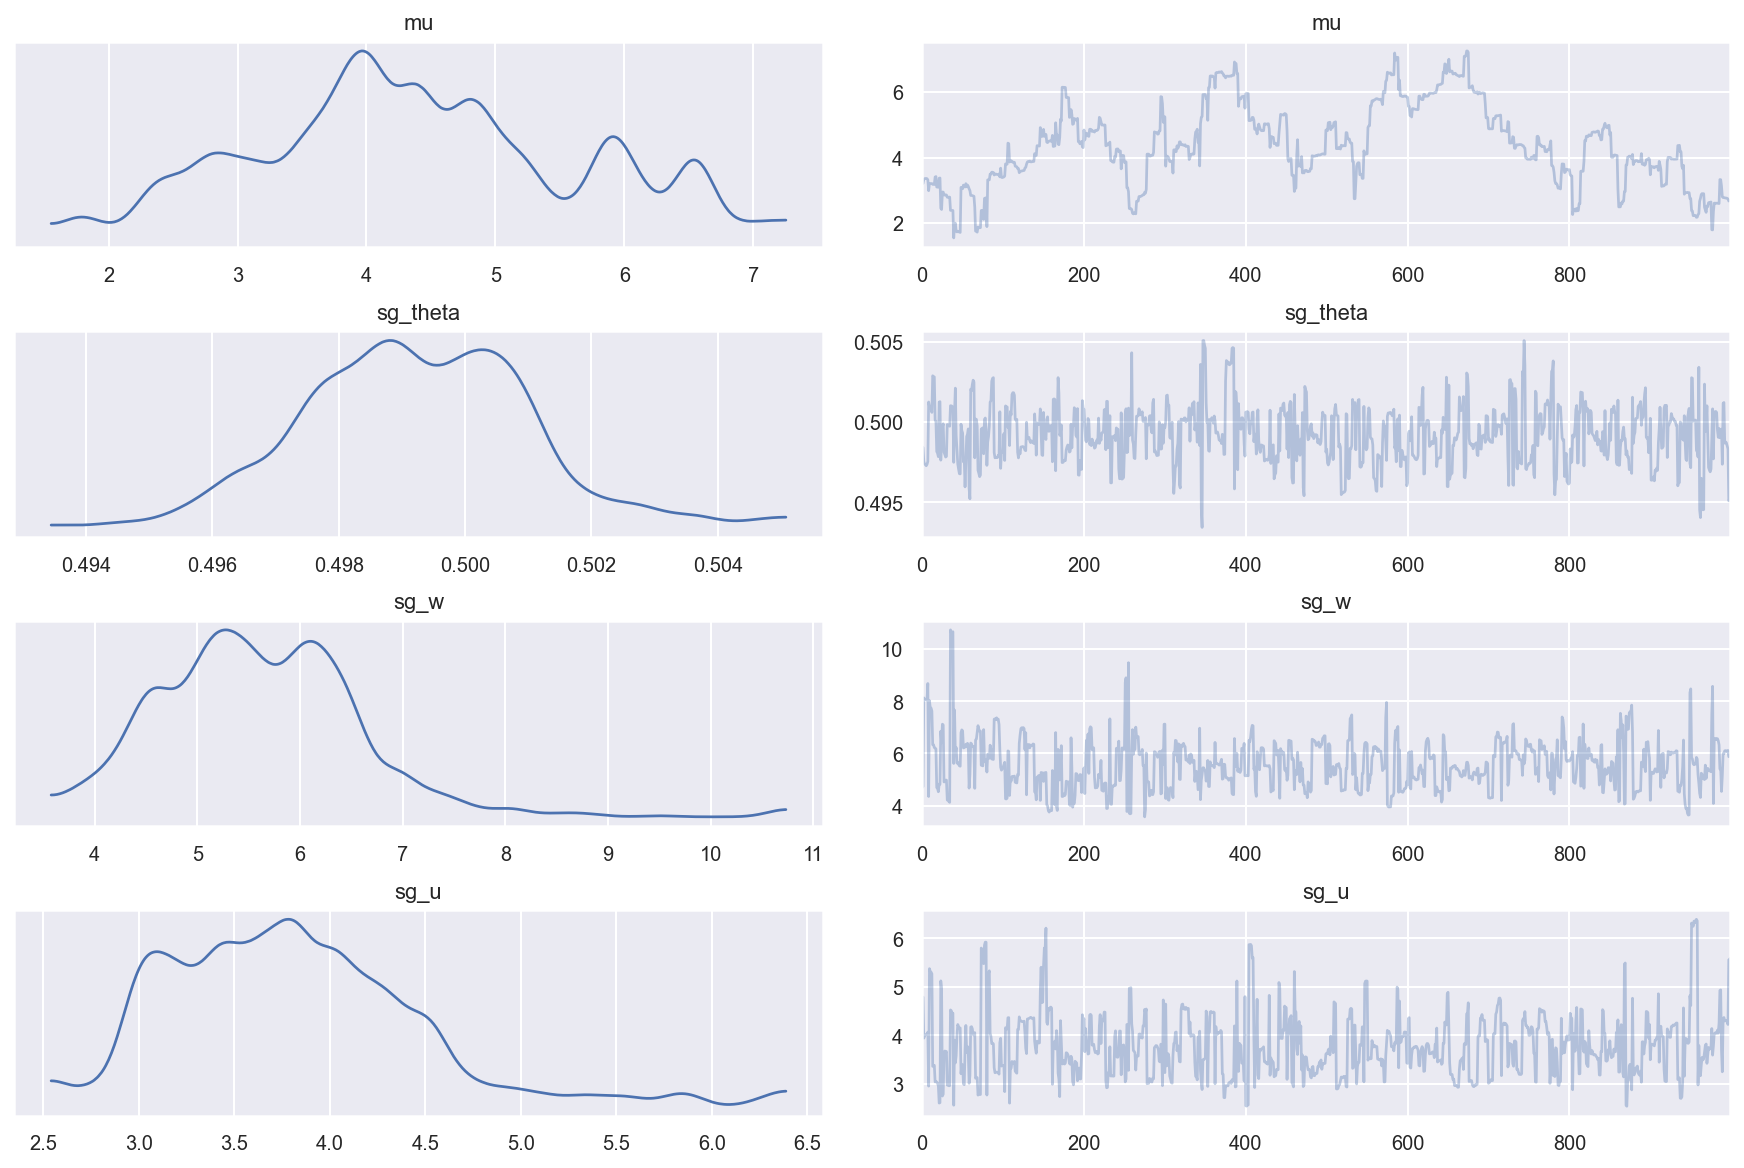

In [37]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu', 'sg_theta', 'sg_w', 'sg_u']);

# Second toy model

## Define model

In [117]:
def model(n_obs, n_u, n_w, d, y):
    sg_w = npr.sample("sg_w", dist.InverseGamma(1, 1))
    sg_u = npr.sample("sg_u", dist.InverseGamma(1, 1))
    sg_theta = npr.sample("sg_theta", dist.InverseGamma(1, 1))
    mu = npr.sample("mu", dist.Normal(0, 10));
    
    with npr.plate("user", n_u):
        U = npr.sample("U", 
                       dist.TransformedDistribution(
                           dist.Normal(0., 1.), 
                           dist.transforms.AffineTransform(0, sg_u)))
    
    with npr.plate("word", n_w):
        W = npr.sample("W", 
                       dist.TransformedDistribution(
                           dist.Normal(0., 1.), 
                           dist.transforms.AffineTransform(0, sg_w)))
    
    with npr.plate("n_obs", n_obs):
        mu_theta = mu + U[u] + W[w]
        theta = npr.sample("theta", 
                           dist.TransformedDistribution(
                               dist.Normal(0., 1.), 
                               [dist.transforms.AffineTransform(mu_theta, sg_theta),
                                dist.transforms.ExpTransform()]))
        # rate = jnp.exp(theta)
        logp = -theta * d
        p = jnp.exp(exponent)
        logits = logp - jnp.log(1-p+jnp.finfo(float).eps)
        npr.sample("obs", dist.Bernoulli(logits=logits), obs=y)

## Create data

[]

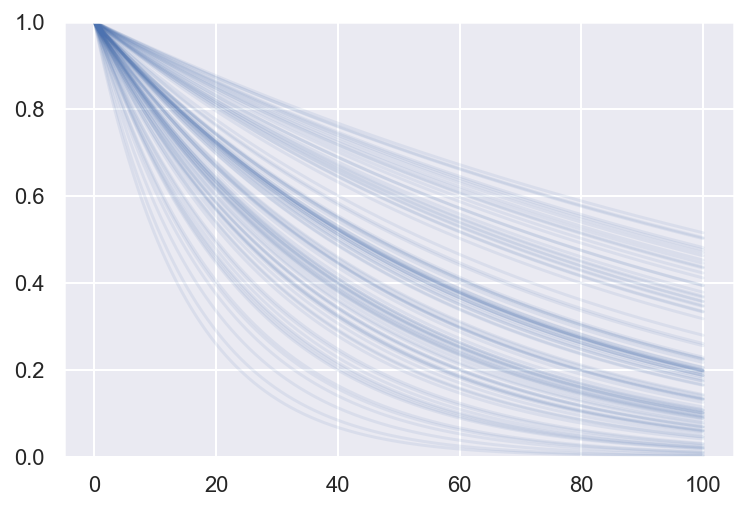

In [118]:
theta = np.random.normal(-4, 0.5, size=100)

fig, ax = plt.subplots()

for th in theta:
    x = np.linspace(0, 100, 1000)
    p = np.exp(-np.exp(th)*x)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1)
plt.plot()

[]

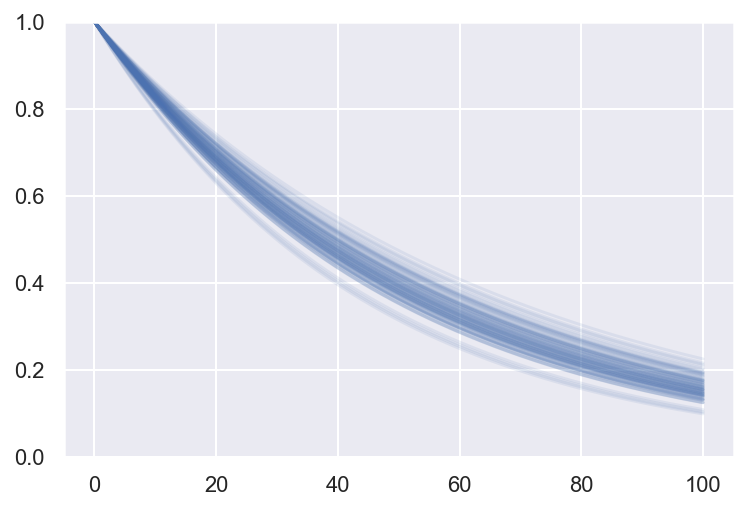

In [119]:
theta = np.random.normal(-4, 0.1, size=100)

fig, ax = plt.subplots()

for th in theta:
    x = np.linspace(0, 100, 1000)
    p = np.exp(-np.exp(th)*x)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1)
plt.plot()

In [120]:
np.random.seed(123)  # Seed

mu = -4
sg_theta = 0.001
sg_u = 0.1
sg_w = 0.5

n_u = 20    # Number of users
n_w = 20    # Number of words
n_o = 100    # Number of obs for one user and one word
n_obs = n_w*n_u*n_o

u = np.zeros(shape=n_obs, dtype=int)
w = np.zeros(shape=n_obs, dtype=int)

idx = 0
for i_w in range(n_w):
    for i_u in range(n_u):
        u[idx:idx+n_o] = i_u
        w[idx:idx+n_o] = i_w
        idx += n_o

U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty
d = np.random.uniform(0, 100, size=n_obs) # Spacing
theta = np.random.normal(mu + U[u] + W[w], sg_theta)
rate = np.exp(theta)
exponent = - rate * d
p = np.exp(exponent)
rd = np.random.random(size=n_obs)
y = (p > rd).astype(int)
        
data = {'n_obs': n_obs, 'n_u': n_u, 'n_w': n_w, 'd': d, 'y': y}

In [121]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.49230919678788687 0.9998737699785589 0.00874143040528058
0.49525 0 1


## Run MCMC

In [122]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, **data)

sample: 100%|██████████| 2000/2000 [13:54<00:00,  2.40it/s, 255 steps of size 1.30e-02. acc. prob=0.92]


In [109]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        U[0]     -0.08      0.06     -0.08     -0.18      0.01     59.90      1.00
        U[1]      0.11      0.06      0.11      0.01      0.21     44.14      1.00
        U[2]     -0.05      0.07     -0.05     -0.15      0.07     34.75      1.04
        U[3]     -0.08      0.07     -0.08     -0.18      0.03     58.88      1.02
        U[4]     -0.12      0.06     -0.11     -0.22     -0.02     50.87      1.00
        U[5]      0.16      0.07      0.16      0.04      0.26     63.03      1.00
        U[6]     -0.25      0.07     -0.26     -0.38     -0.14     30.76      1.02
        U[7]     -0.06      0.06     -0.06     -0.15      0.04     81.94      1.02
        U[8]      0.18      0.06      0.18      0.09      0.29    104.76      1.00
        U[9]     -0.08      0.06     -0.08     -0.19      0.01     69.52      1.02
       U[10]     -0.09      0.07     -0.09     -0.20      0.02     26.70      1.22
   

 theta[1712]     -3.44      0.34     -3.43     -3.97     -2.88   1015.40      1.00
 theta[1713]     -3.41      0.33     -3.42     -4.01     -2.94   1150.00      1.00
 theta[1714]     -3.42      0.33     -3.41     -3.97     -2.88    692.26      1.00
 theta[1715]     -3.50      0.30     -3.50     -3.95     -2.98    869.22      1.00
 theta[1716]     -3.40      0.33     -3.40     -3.97     -2.91    788.74      1.00
 theta[1717]     -3.42      0.33     -3.41     -3.94     -2.90    706.00      1.01
 theta[1718]     -3.40      0.35     -3.40     -3.92     -2.77    991.88      1.00
 theta[1719]     -3.52      0.31     -3.52     -4.02     -2.99    784.83      1.00
 theta[1720]     -3.46      0.33     -3.46     -4.00     -2.94   1479.10      1.00
 theta[1721]     -3.41      0.33     -3.40     -3.95     -2.88   1079.90      1.00
 theta[1722]     -3.40      0.36     -3.39     -3.98     -2.79   1583.48      1.00
 theta[1723]     -3.43      0.35     -3.43     -3.93     -2.76   1164.33      1.00
 the

 theta[3212]     -3.09      0.34     -3.09     -3.64     -2.53    945.39      1.00
 theta[3213]     -3.08      0.34     -3.09     -3.68     -2.56    981.29      1.00
 theta[3214]     -3.10      0.33     -3.09     -3.66     -2.62   1005.26      1.00
 theta[3215]     -3.11      0.35     -3.14     -3.65     -2.46   1612.02      1.00
 theta[3216]     -3.07      0.33     -3.08     -3.56     -2.53   1143.01      1.00
 theta[3217]     -3.10      0.33     -3.09     -3.62     -2.60   1387.91      1.00
 theta[3218]     -3.08      0.33     -3.07     -3.61     -2.53   1310.47      1.00
 theta[3219]     -3.08      0.30     -3.09     -3.56     -2.58    757.29      1.00
 theta[3220]     -3.10      0.34     -3.08     -3.69     -2.60    872.40      1.00
 theta[3221]     -3.09      0.31     -3.11     -3.61     -2.59   1080.54      1.00
 theta[3222]     -3.09      0.34     -3.09     -3.63     -2.54   1052.68      1.00
 theta[3223]     -3.09      0.36     -3.08     -3.69     -2.53    928.66      1.00
 the

 theta[4711]     -4.65      0.33     -4.64     -5.14     -4.07   1362.93      1.00
 theta[4712]     -4.62      0.35     -4.61     -5.21     -4.06   1264.50      1.00
 theta[4713]     -4.65      0.35     -4.65     -5.16     -4.03    879.64      1.00
 theta[4714]     -4.61      0.33     -4.60     -5.18     -4.10    870.72      1.00
 theta[4715]     -4.61      0.33     -4.60     -5.18     -4.11    692.61      1.00
 theta[4716]     -4.67      0.32     -4.66     -5.24     -4.17   1146.53      1.00
 theta[4717]     -4.61      0.34     -4.60     -5.12     -4.01    696.15      1.00
 theta[4718]     -4.63      0.35     -4.61     -5.22     -4.05   1186.20      1.00
 theta[4719]     -4.67      0.31     -4.67     -5.20     -4.21   1363.70      1.00
 theta[4720]     -4.60      0.33     -4.59     -5.17     -4.11    810.78      1.00
 theta[4721]     -4.59      0.35     -4.59     -5.28     -4.11    831.34      1.00
 theta[4722]     -4.69      0.32     -4.69     -5.21     -4.17    791.70      1.00
 the

 theta[6211]     -3.53      0.30     -3.53     -3.97     -3.00   1001.44      1.00
 theta[6212]     -3.69      0.30     -3.70     -4.17     -3.20    999.32      1.00
 theta[6213]     -3.60      0.29     -3.59     -4.07     -3.13    902.87      1.00
 theta[6214]     -3.40      0.36     -3.40     -3.97     -2.80   1223.32      1.00
 theta[6215]     -3.46      0.33     -3.45     -4.04     -2.95    808.95      1.00
 theta[6216]     -3.40      0.32     -3.40     -3.92     -2.90    418.59      1.00
 theta[6217]     -3.41      0.33     -3.41     -3.91     -2.82   1133.84      1.00
 theta[6218]     -3.51      0.32     -3.53     -4.03     -3.00   1044.87      1.00
 theta[6219]     -3.43      0.36     -3.43     -3.99     -2.84   1295.62      1.00
 theta[6220]     -3.41      0.33     -3.40     -3.98     -2.91    584.82      1.00
 theta[6221]     -3.41      0.34     -3.40     -3.92     -2.85    931.82      1.00
 theta[6222]     -3.46      0.32     -3.47     -4.01     -2.95    870.06      1.00
 the

 theta[7710]     -3.28      0.32     -3.28     -3.75     -2.71   1395.43      1.00
 theta[7711]     -3.18      0.31     -3.18     -3.69     -2.71    611.38      1.01
 theta[7712]     -3.17      0.31     -3.17     -3.63     -2.63   1081.94      1.00
 theta[7713]     -3.17      0.33     -3.16     -3.69     -2.57   1011.52      1.00
 theta[7714]     -3.18      0.32     -3.17     -3.69     -2.66    746.29      1.00
 theta[7715]     -3.16      0.33     -3.16     -3.70     -2.60   1105.07      1.01
 theta[7716]     -3.18      0.31     -3.18     -3.70     -2.66   1145.19      1.00
 theta[7717]     -3.16      0.34     -3.17     -3.67     -2.58    835.51      1.00
 theta[7718]     -3.15      0.33     -3.16     -3.67     -2.63    869.70      1.00
 theta[7719]     -3.16      0.32     -3.15     -3.70     -2.69    767.24      1.00
 theta[7720]     -3.18      0.34     -3.17     -3.69     -2.58   1704.64      1.00
 theta[7721]     -3.16      0.33     -3.17     -3.66     -2.61    813.79      1.00
 the

 theta[9210]     -4.49      0.33     -4.49     -5.03     -3.96    590.99      1.00
 theta[9211]     -4.45      0.33     -4.46     -4.96     -3.89    431.64      1.00
 theta[9212]     -4.45      0.35     -4.45     -5.02     -3.84    391.62      1.00
 theta[9213]     -4.49      0.34     -4.49     -5.06     -3.95    419.64      1.00
 theta[9214]     -4.54      0.32     -4.54     -5.01     -3.96    458.58      1.00
 theta[9215]     -4.44      0.35     -4.42     -5.07     -3.94    484.91      1.00
 theta[9216]     -4.49      0.34     -4.49     -5.05     -3.96    660.72      1.00
 theta[9217]     -4.45      0.33     -4.46     -5.05     -3.98    356.21      1.00
 theta[9218]     -4.52      0.33     -4.52     -5.08     -4.00    484.33      1.00
 theta[9219]     -4.44      0.34     -4.44     -4.97     -3.87    359.65      1.00
 theta[9220]     -4.49      0.34     -4.47     -5.06     -3.99    450.57      1.00
 theta[9221]     -4.48      0.32     -4.47     -4.96     -3.94    399.69      1.00
 the

theta[10709]     -4.37      0.37     -4.37     -5.03     -3.79    612.14      1.00
theta[10710]     -4.36      0.33     -4.36     -4.88     -3.84    527.88      1.00
theta[10711]     -4.37      0.31     -4.37     -4.94     -3.91    322.62      1.00
theta[10712]     -4.45      0.32     -4.46     -4.98     -3.93    503.55      1.00
theta[10713]     -4.49      0.31     -4.50     -5.02     -4.01    520.69      1.00
theta[10714]     -4.39      0.34     -4.37     -4.89     -3.80    842.17      1.00
theta[10715]     -4.41      0.31     -4.42     -4.94     -3.95    459.50      1.00
theta[10716]     -4.46      0.31     -4.46     -5.01     -4.00    512.36      1.00
theta[10717]     -4.42      0.31     -4.41     -4.90     -3.88    522.70      1.00
theta[10718]     -4.37      0.32     -4.38     -4.85     -3.85    818.03      1.00
theta[10719]     -4.42      0.32     -4.41     -4.94     -3.91    329.95      1.00
theta[10720]     -4.36      0.35     -4.37     -4.93     -3.79    647.85      1.00
thet

theta[12209]     -3.60      0.33     -3.60     -4.18     -3.11   1090.31      1.00
theta[12210]     -3.57      0.32     -3.56     -4.12     -3.07    805.64      1.01
theta[12211]     -3.58      0.32     -3.56     -4.09     -3.07    607.61      1.01
theta[12212]     -3.75      0.30     -3.74     -4.21     -3.25    969.35      1.00
theta[12213]     -3.57      0.32     -3.56     -4.04     -2.97   1290.28      1.00
theta[12214]     -3.56      0.30     -3.57     -4.05     -3.10    667.88      1.00
theta[12215]     -3.56      0.35     -3.57     -4.20     -3.05    845.71      1.01
theta[12216]     -3.57      0.33     -3.57     -4.08     -2.98   1141.10      1.00
theta[12217]     -3.71      0.30     -3.71     -4.19     -3.19   1489.99      1.00
theta[12218]     -3.59      0.34     -3.58     -4.16     -3.04   1268.19      1.00
theta[12219]     -3.55      0.36     -3.54     -4.21     -3.00   1132.68      1.01
theta[12220]     -3.60      0.34     -3.59     -4.17     -3.08    784.35      1.01
thet

theta[13708]     -3.33      0.32     -3.33     -3.85     -2.81    480.53      1.01
theta[13709]     -3.38      0.33     -3.37     -3.91     -2.85    809.88      1.01
theta[13710]     -3.32      0.32     -3.32     -3.89     -2.83    623.72      1.01
theta[13711]     -3.32      0.32     -3.33     -3.82     -2.81    650.80      1.00
theta[13712]     -3.34      0.33     -3.36     -3.83     -2.78    905.09      1.00
theta[13713]     -3.42      0.33     -3.42     -3.94     -2.90    699.27      1.01
theta[13714]     -3.32      0.33     -3.31     -3.86     -2.82    911.81      1.01
theta[13715]     -3.33      0.32     -3.34     -3.87     -2.81    703.34      1.01
theta[13716]     -3.31      0.33     -3.30     -3.83     -2.78   1154.24      1.00
theta[13717]     -3.33      0.34     -3.33     -3.88     -2.80   1062.72      1.00
theta[13718]     -3.33      0.34     -3.32     -3.92     -2.80    565.80      1.01
theta[13719]     -3.35      0.33     -3.35     -3.95     -2.87    528.49      1.01
thet

theta[15208]     -4.75      0.33     -4.76     -5.28     -4.21    591.57      1.01
theta[15209]     -4.71      0.33     -4.72     -5.20     -4.12    457.28      1.00
theta[15210]     -4.70      0.35     -4.69     -5.28     -4.16    479.73      1.01
theta[15211]     -4.72      0.34     -4.72     -5.29     -4.19    380.27      1.01
theta[15212]     -4.69      0.33     -4.68     -5.24     -4.17    518.91      1.00
theta[15213]     -4.72      0.36     -4.71     -5.28     -4.14    360.68      1.00
theta[15214]     -4.65      0.35     -4.65     -5.26     -4.13    424.90      1.01
theta[15215]     -4.70      0.34     -4.70     -5.19     -4.10    329.10      1.01
theta[15216]     -4.70      0.34     -4.68     -5.25     -4.18    495.70      1.01
theta[15217]     -4.71      0.30     -4.70     -5.16     -4.23    277.78      1.01
theta[15218]     -4.72      0.32     -4.71     -5.24     -4.21    596.69      1.01
theta[15219]     -4.66      0.33     -4.66     -5.21     -4.14    267.27      1.01
thet

theta[16707]     -4.15      0.33     -4.15     -4.71     -3.62    670.41      1.00
theta[16708]     -4.11      0.34     -4.12     -4.66     -3.57    775.17      1.00
theta[16709]     -4.12      0.31     -4.14     -4.64     -3.64    840.57      1.00
theta[16710]     -4.09      0.36     -4.09     -4.72     -3.55    849.58      1.00
theta[16711]     -4.16      0.32     -4.16     -4.61     -3.53    762.30      1.00
theta[16712]     -4.19      0.34     -4.19     -4.81     -3.67   1067.92      1.00
theta[16713]     -4.11      0.34     -4.11     -4.71     -3.62    642.40      1.00
theta[16714]     -4.12      0.34     -4.13     -4.65     -3.54   1053.71      1.00
theta[16715]     -4.11      0.35     -4.11     -4.72     -3.55   1190.33      1.00
theta[16716]     -4.17      0.33     -4.16     -4.71     -3.67    751.67      1.00
theta[16717]     -4.11      0.35     -4.10     -4.73     -3.60    745.27      1.00
theta[16718]     -4.12      0.33     -4.12     -4.68     -3.60    953.77      1.00
thet

theta[18207]     -4.48      0.32     -4.46     -5.03     -3.95    318.93      1.01
theta[18208]     -4.48      0.32     -4.48     -5.04     -3.99    290.45      1.00
theta[18209]     -4.48      0.35     -4.49     -5.03     -3.90    439.35      1.00
theta[18210]     -4.48      0.35     -4.47     -5.09     -3.98    393.32      1.00
theta[18211]     -4.52      0.35     -4.52     -5.09     -3.96    573.14      1.00
theta[18212]     -4.49      0.34     -4.48     -5.02     -3.93    300.12      1.01
theta[18213]     -4.47      0.34     -4.47     -5.10     -3.97    425.41      1.00
theta[18214]     -4.47      0.33     -4.48     -4.98     -3.88    641.08      1.01
theta[18215]     -4.49      0.34     -4.50     -5.01     -3.90    359.34      1.00
theta[18216]     -4.48      0.31     -4.48     -4.99     -3.98    381.73      1.00
theta[18217]     -4.48      0.34     -4.47     -5.06     -3.94    481.48      1.00
theta[18218]     -4.51      0.32     -4.53     -5.03     -4.00    398.37      1.00
thet

theta[19541]     -4.54      0.34     -4.54     -5.06     -3.96   1033.85      1.00
theta[19542]     -4.54      0.33     -4.54     -5.06     -3.99    764.92      1.01
theta[19543]     -4.61      0.33     -4.61     -5.11     -4.05    752.22      1.00
theta[19544]     -4.62      0.32     -4.62     -5.13     -4.10    480.25      1.01
theta[19545]     -4.53      0.34     -4.54     -5.07     -3.97    309.97      1.01
theta[19546]     -4.61      0.33     -4.62     -5.12     -4.08    480.71      1.01
theta[19547]     -4.58      0.32     -4.59     -5.11     -4.04    337.28      1.01
theta[19548]     -4.53      0.34     -4.54     -5.03     -3.97    458.36      1.00
theta[19549]     -4.54      0.34     -4.54     -5.12     -4.01    646.52      1.00
theta[19550]     -4.58      0.32     -4.56     -5.11     -4.06    923.51      1.01
theta[19551]     -4.57      0.35     -4.57     -5.07     -3.95    890.67      1.00
theta[19552]     -4.54      0.33     -4.55     -5.11     -4.03    622.43      1.00
thet

theta[20845]     -3.91      0.33     -3.92     -4.40     -3.32   1100.08      1.00
theta[20846]     -4.01      0.33     -4.01     -4.57     -3.46    924.41      1.00
theta[20847]     -4.03      0.32     -4.04     -4.54     -3.52   1385.05      1.00
theta[20848]     -3.93      0.30     -3.93     -4.43     -3.44   1184.64      1.00
theta[20849]     -3.92      0.35     -3.92     -4.45     -3.35   1569.37      1.00
theta[20850]     -3.95      0.32     -3.95     -4.49     -3.45   1471.62      1.00
theta[20851]     -3.95      0.34     -3.93     -4.48     -3.38   1601.32      1.00
theta[20852]     -4.04      0.30     -4.04     -4.55     -3.58    984.48      1.00
theta[20853]     -3.91      0.34     -3.91     -4.48     -3.41   1378.91      1.00
theta[20854]     -3.91      0.32     -3.92     -4.47     -3.43    976.23      1.00
theta[20855]     -3.98      0.32     -3.98     -4.52     -3.45   1494.00      1.00
theta[20856]     -4.05      0.32     -4.05     -4.56     -3.54   1484.99      1.00
thet

theta[22304]     -5.40      0.34     -5.40     -5.92     -4.81    260.05      1.02
theta[22305]     -5.42      0.36     -5.43     -5.98     -4.81    338.34      1.01
theta[22306]     -5.42      0.36     -5.40     -5.97     -4.85    255.56      1.01
theta[22307]     -5.43      0.35     -5.44     -5.98     -4.86    262.95      1.01
theta[22308]     -5.41      0.34     -5.40     -5.97     -4.87    222.83      1.01
theta[22309]     -5.37      0.35     -5.36     -5.93     -4.80    399.46      1.01
theta[22310]     -5.40      0.33     -5.41     -5.93     -4.85    246.02      1.01
theta[22311]     -5.41      0.31     -5.41     -5.88     -4.87    158.91      1.03
theta[22312]     -5.42      0.34     -5.43     -5.94     -4.83    243.58      1.02
theta[22313]     -5.42      0.33     -5.45     -5.92     -4.86    263.60      1.03
theta[22314]     -5.42      0.34     -5.42     -5.95     -4.85    209.82      1.02
theta[22315]     -5.43      0.35     -5.44     -6.04     -4.90    262.67      1.01
thet

theta[23714]     -5.12      0.33     -5.12     -5.71     -4.61     67.91      1.05
theta[23715]     -5.12      0.35     -5.13     -5.72     -4.55     89.83      1.04
theta[23716]     -5.13      0.33     -5.15     -5.62     -4.57     93.35      1.03
theta[23717]     -5.09      0.35     -5.10     -5.63     -4.49     82.16      1.04
theta[23718]     -5.13      0.34     -5.13     -5.60     -4.47    160.26      1.03
theta[23719]     -5.14      0.31     -5.14     -5.62     -4.58     76.06      1.04
theta[23720]     -5.10      0.35     -5.10     -5.65     -4.55     71.53      1.04
theta[23721]     -5.14      0.35     -5.14     -5.68     -4.54     67.73      1.05
theta[23722]     -5.16      0.35     -5.15     -5.73     -4.58    122.28      1.02
theta[23723]     -5.13      0.35     -5.13     -5.73     -4.59    138.45      1.03
theta[23724]     -5.15      0.33     -5.14     -5.69     -4.64    102.56      1.03
theta[23725]     -5.10      0.34     -5.09     -5.75     -4.62    121.29      1.03
thet

theta[25087]     -4.90      0.38     -4.90     -5.55     -4.34     96.67      1.00
theta[25088]     -4.93      0.36     -4.94     -5.55     -4.39     91.30      1.00
theta[25089]     -4.91      0.34     -4.92     -5.43     -4.33     69.73      1.00
theta[25090]     -4.96      0.34     -4.95     -5.48     -4.37    118.09      1.00
theta[25091]     -4.90      0.36     -4.91     -5.45     -4.28     66.77      1.00
theta[25092]     -4.95      0.34     -4.95     -5.55     -4.46     80.86      1.00
theta[25093]     -4.96      0.35     -4.95     -5.54     -4.40     98.29      1.00
theta[25094]     -4.90      0.35     -4.90     -5.46     -4.33     76.31      1.00
theta[25095]     -4.91      0.37     -4.92     -5.52     -4.32    127.27      1.00
theta[25096]     -4.92      0.37     -4.91     -5.49     -4.28     86.48      1.00
theta[25097]     -4.94      0.34     -4.95     -5.47     -4.37     78.13      1.00
theta[25098]     -4.91      0.33     -4.91     -5.48     -4.41     78.36      1.00
thet

theta[26437]     -4.49      0.33     -4.50     -5.04     -3.96    565.65      1.00
theta[26438]     -4.52      0.34     -4.52     -5.00     -3.94    967.72      1.00
theta[26439]     -4.41      0.32     -4.41     -5.02     -3.93    599.45      1.00
theta[26440]     -4.41      0.31     -4.41     -4.91     -3.91    540.97      1.01
theta[26441]     -4.52      0.33     -4.52     -5.09     -4.03    538.28      1.00
theta[26442]     -4.50      0.31     -4.50     -4.97     -3.92    685.70      1.00
theta[26443]     -4.43      0.34     -4.42     -5.03     -3.93    652.67      1.00
theta[26444]     -4.47      0.34     -4.47     -5.02     -3.92    936.46      1.00
theta[26445]     -4.48      0.30     -4.49     -4.97     -4.00    751.62      1.00
theta[26446]     -4.44      0.34     -4.43     -5.02     -3.93    564.11      1.01
theta[26447]     -4.52      0.32     -4.52     -5.06     -4.02    702.37      1.00
theta[26448]     -4.42      0.32     -4.42     -4.96     -3.92    535.42      1.00
thet

theta[27733]     -4.10      0.33     -4.10     -4.63     -3.56    889.83      1.00
theta[27734]     -4.11      0.33     -4.11     -4.66     -3.58    698.98      1.00
theta[27735]     -4.11      0.33     -4.11     -4.67     -3.60    749.78      1.00
theta[27736]     -4.12      0.33     -4.12     -4.64     -3.57    857.21      1.00
theta[27737]     -4.11      0.34     -4.12     -4.71     -3.59    827.33      1.00
theta[27738]     -4.12      0.33     -4.12     -4.63     -3.55   1355.12      1.00
theta[27739]     -4.11      0.33     -4.11     -4.69     -3.57    893.20      1.00
theta[27740]     -4.21      0.31     -4.21     -4.76     -3.72   1029.77      1.00
theta[27741]     -4.11      0.33     -4.09     -4.67     -3.59    770.53      1.00
theta[27742]     -4.12      0.34     -4.11     -4.63     -3.54    948.03      1.00
theta[27743]     -4.17      0.31     -4.18     -4.65     -3.65   1059.26      1.00
theta[27744]     -4.14      0.31     -4.15     -4.65     -3.61    733.27      1.00
thet

theta[29703]     -3.28      0.33     -3.28     -3.75     -2.70    793.79      1.01
theta[29704]     -3.26      0.36     -3.26     -3.90     -2.75   1462.20      1.01
theta[29705]     -3.25      0.31     -3.25     -3.75     -2.73    955.83      1.00
theta[29706]     -3.25      0.34     -3.24     -3.81     -2.73   1166.37      1.00
theta[29707]     -3.26      0.33     -3.27     -3.79     -2.70   1034.98      1.00
theta[29708]     -3.24      0.33     -3.24     -3.75     -2.70   1174.00      1.01
theta[29709]     -3.25      0.31     -3.26     -3.76     -2.74    918.96      1.01
theta[29710]     -3.23      0.35     -3.23     -3.89     -2.74    971.50      1.00
theta[29711]     -3.40      0.31     -3.38     -3.89     -2.89    959.34      1.00
theta[29712]     -3.27      0.32     -3.26     -3.81     -2.77    813.83      1.00
theta[29713]     -3.27      0.32     -3.28     -3.75     -2.68    745.39      1.01
theta[29714]     -3.27      0.32     -3.28     -3.76     -2.74    752.42      1.00
thet

theta[31202]     -3.95      0.32     -3.95     -4.45     -3.41    660.08      1.00
theta[31203]     -3.90      0.33     -3.88     -4.41     -3.36    486.77      1.00
theta[31204]     -3.90      0.32     -3.90     -4.45     -3.40    767.31      1.00
theta[31205]     -3.89      0.35     -3.89     -4.44     -3.29   1001.42      1.00
theta[31206]     -3.89      0.33     -3.89     -4.44     -3.37    485.86      1.00
theta[31207]     -3.90      0.34     -3.90     -4.46     -3.37    791.77      1.00
theta[31208]     -3.89      0.35     -3.90     -4.50     -3.35   1458.09      1.00
theta[31209]     -3.93      0.34     -3.93     -4.50     -3.37    897.98      1.00
theta[31210]     -3.98      0.32     -3.98     -4.45     -3.40    703.00      1.00
theta[31211]     -3.89      0.35     -3.90     -4.43     -3.29    868.73      1.00
theta[31212]     -3.90      0.33     -3.89     -4.42     -3.39    447.49      1.00
theta[31213]     -3.98      0.33     -3.97     -4.55     -3.48    855.49      1.00
thet

theta[32702]     -4.10      0.32     -4.10     -4.63     -3.57   1465.19      1.00
theta[32703]     -4.15      0.32     -4.15     -4.70     -3.64   1798.13      1.00
theta[32704]     -4.09      0.34     -4.10     -4.64     -3.54   1421.30      1.00
theta[32705]     -4.08      0.33     -4.07     -4.65     -3.59   1476.83      1.00
theta[32706]     -4.13      0.32     -4.14     -4.66     -3.63   1765.05      1.00
theta[32707]     -4.15      0.32     -4.14     -4.70     -3.64   1461.27      1.00
theta[32708]     -4.18      0.31     -4.18     -4.66     -3.66   1884.08      1.00
theta[32709]     -4.10      0.35     -4.10     -4.68     -3.56   1217.17      1.00
theta[32710]     -4.12      0.32     -4.12     -4.65     -3.61   1286.88      1.00
theta[32711]     -4.15      0.31     -4.13     -4.67     -3.66   1632.55      1.00
theta[32712]     -4.17      0.31     -4.17     -4.72     -3.66   1953.53      1.00
theta[32713]     -4.08      0.31     -4.08     -4.62     -3.61   1504.90      1.00
thet

theta[34201]     -3.68      0.30     -3.69     -4.19     -3.19    534.97      1.00
theta[34202]     -3.68      0.31     -3.66     -4.15     -3.17    648.00      1.00
theta[34203]     -3.85      0.31     -3.86     -4.33     -3.34   1224.92      1.00
theta[34204]     -3.69      0.33     -3.70     -4.16     -3.09   1007.22      1.00
theta[34205]     -3.67      0.33     -3.66     -4.20     -3.15    747.85      1.00
theta[34206]     -3.69      0.32     -3.68     -4.24     -3.19   1348.09      1.00
theta[34207]     -3.73      0.33     -3.74     -4.32     -3.22    817.66      1.00
theta[34208]     -3.68      0.34     -3.69     -4.24     -3.12   1207.64      1.00
theta[34209]     -3.69      0.33     -3.68     -4.22     -3.17    981.87      1.00
theta[34210]     -3.72      0.32     -3.72     -4.24     -3.20    625.20      1.00
theta[34211]     -3.72      0.34     -3.72     -4.28     -3.15   1220.49      1.00
theta[34212]     -3.68      0.34     -3.68     -4.24     -3.11    986.22      1.00
thet

theta[35701]     -3.43      0.31     -3.44     -3.92     -2.92    987.14      1.00
theta[35702]     -3.44      0.35     -3.44     -4.04     -2.92   1438.09      1.00
theta[35703]     -3.42      0.33     -3.43     -3.95     -2.90    999.43      1.00
theta[35704]     -3.59      0.31     -3.58     -4.13     -3.12   1240.57      1.00
theta[35705]     -3.43      0.35     -3.43     -3.94     -2.79    960.17      1.00
theta[35706]     -3.44      0.32     -3.45     -3.93     -2.91   1689.51      1.00
theta[35707]     -3.43      0.34     -3.42     -4.01     -2.88   1278.79      1.00
theta[35708]     -3.52      0.32     -3.52     -4.04     -2.98   1398.35      1.00
theta[35709]     -3.44      0.34     -3.45     -3.99     -2.88    967.69      1.00
theta[35710]     -3.44      0.31     -3.44     -3.95     -2.94   1007.91      1.00
theta[35711]     -3.46      0.34     -3.47     -4.08     -2.94   1729.87      1.00
theta[35712]     -3.43      0.34     -3.43     -4.05     -2.93   1108.29      1.00
thet

theta[37200]     -4.45      0.32     -4.44     -5.01     -3.94    448.96      1.01
theta[37201]     -4.51      0.33     -4.49     -5.05     -4.00    412.48      1.01
theta[37202]     -4.45      0.35     -4.45     -5.02     -3.88    249.76      1.01
theta[37203]     -4.56      0.31     -4.57     -5.09     -4.05    322.53      1.01
theta[37204]     -4.49      0.34     -4.49     -5.03     -3.95    328.59      1.01
theta[37205]     -4.45      0.33     -4.45     -5.00     -3.92    260.13      1.01
theta[37206]     -4.48      0.36     -4.49     -5.06     -3.88    432.23      1.00
theta[37207]     -4.51      0.33     -4.52     -5.11     -4.01    347.19      1.00
theta[37208]     -4.46      0.35     -4.46     -5.01     -3.83    422.84      1.00
theta[37209]     -4.48      0.35     -4.49     -5.05     -3.88    271.95      1.00
theta[37210]     -4.49      0.33     -4.50     -5.01     -3.91    479.36      1.01
theta[37211]     -4.52      0.32     -4.52     -5.04     -4.00    278.76      1.00
thet

theta[38700]     -3.94      0.34     -3.94     -4.54     -3.43   1330.76      1.00
theta[38701]     -4.00      0.33     -3.99     -4.58     -3.50   1268.80      1.00
theta[38702]     -4.06      0.30     -4.06     -4.52     -3.57    706.97      1.00
theta[38703]     -4.09      0.30     -4.10     -4.56     -3.57    790.61      1.00
theta[38704]     -3.95      0.34     -3.95     -4.47     -3.38    906.43      1.00
theta[38705]     -4.06      0.31     -4.06     -4.52     -3.52    997.17      1.00
theta[38706]     -3.99      0.34     -4.02     -4.53     -3.41    553.76      1.00
theta[38707]     -3.94      0.33     -3.94     -4.38     -3.33    954.98      1.00
theta[38708]     -3.94      0.34     -3.94     -4.51     -3.39    740.72      1.00
theta[38709]     -4.05      0.31     -4.04     -4.56     -3.53    806.99      1.00
theta[38710]     -3.99      0.33     -3.98     -4.53     -3.47    813.24      1.00
theta[38711]     -3.95      0.34     -3.94     -4.47     -3.39   1210.71      1.00
thet

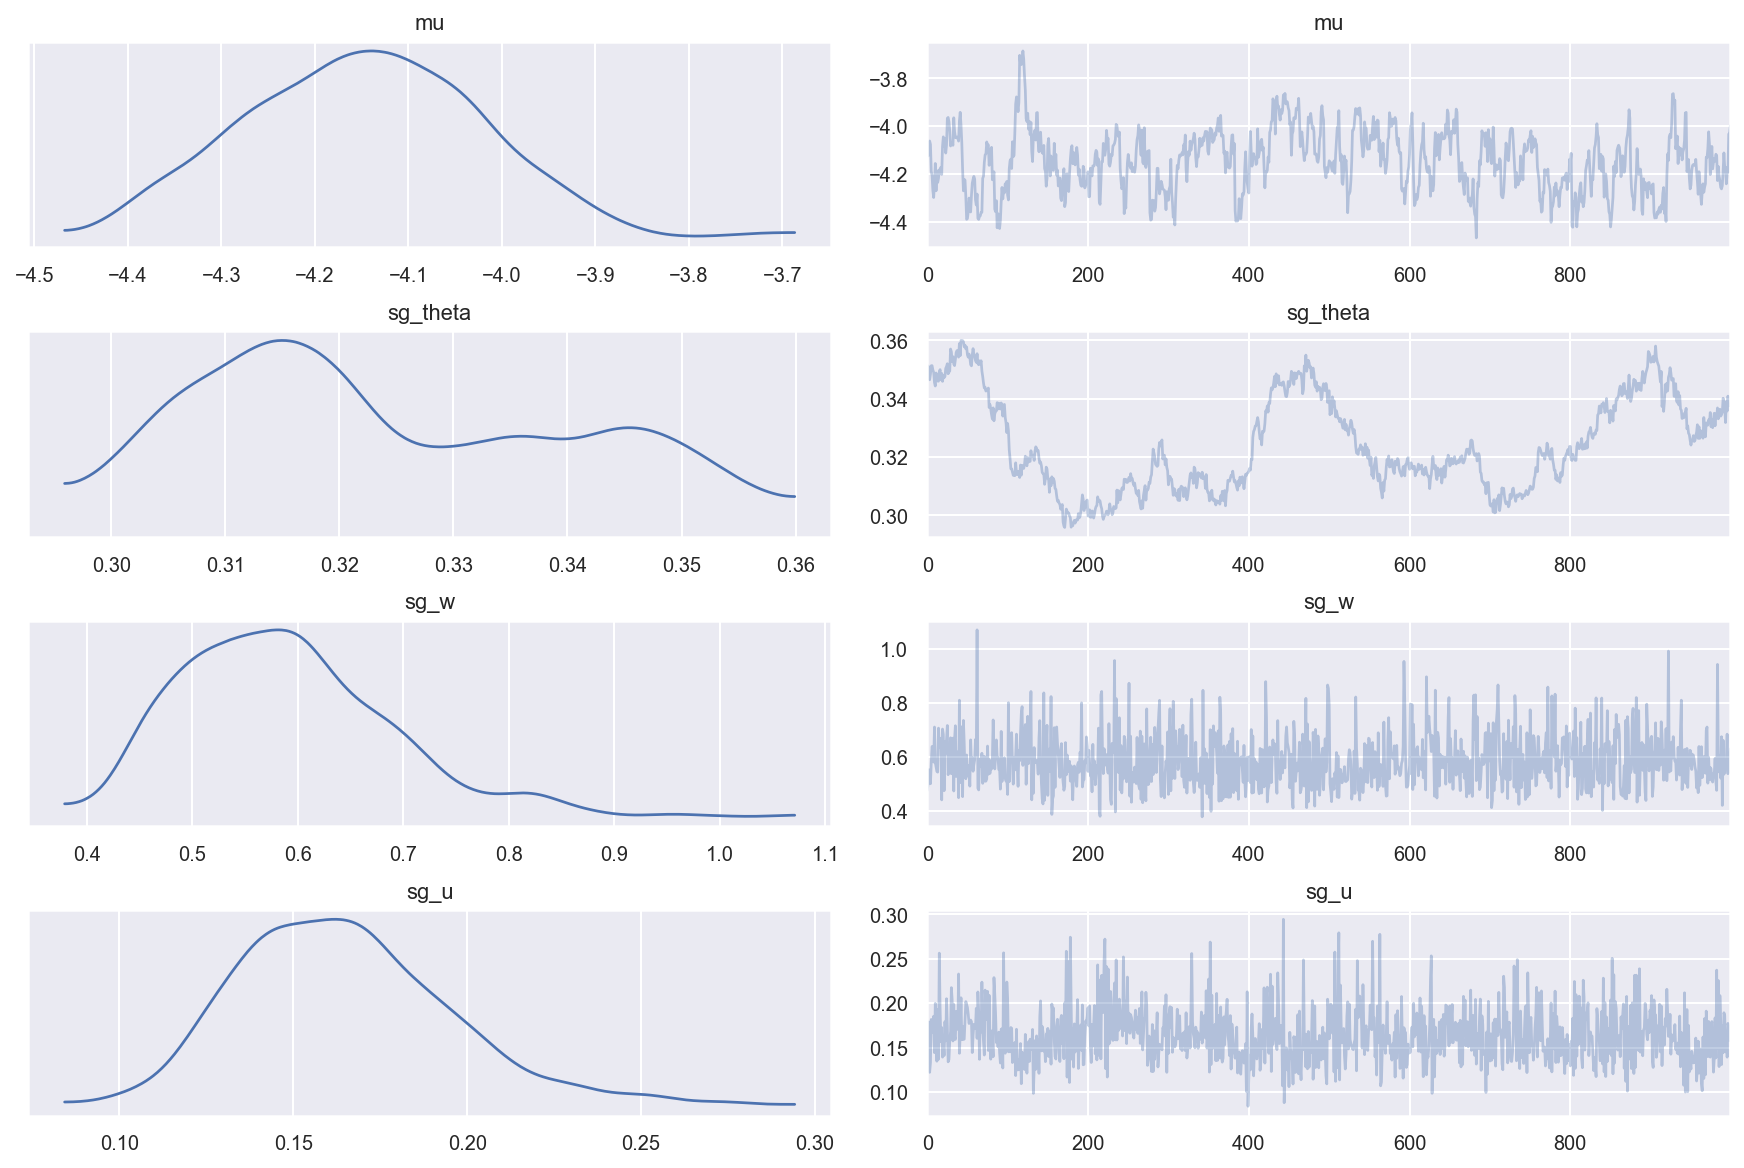

In [110]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu', 'sg_theta', 'sg_w', 'sg_u']);